In [11]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [12]:
root = './distilled_dataset'

### CIFAR100 Distilled

In [13]:
class CIFAR100_Distilled(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, torch.tensor(label)

In [14]:
index_file = pd.read_csv('./CIFAR100_DM_index_files/ipc100_idx.csv')
index_file

,image_path,label
0,./CIFAR100_DM/ipc100/class0/00169883-da36-44ac...,0
1,./CIFAR100_DM/ipc100/class0/03979495-b927-4b32...,0
2,./CIFAR100_DM/ipc100/class0/06bbf568-f1cf-4b0e...,0
3,./CIFAR100_DM/ipc100/class0/09183e31-0bf4-4106...,0
4,./CIFAR100_DM/ipc100/class0/0a1dddd0-2ee6-4023...,0
...,...,...
9995,./CIFAR100_DM/ipc100/class99/f9820d24-1cb4-486...,99
9996,./CIFAR100_DM/ipc100/class99/fbf46794-ec4a-413...,99
9997,./CIFAR100_DM/ipc100/class99/fd2ebea7-390b-448...,99
9998,./CIFAR100_DM/ipc100/class99/fd655351-a9e2-45c...,99


In [15]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar100_distilled_train = CIFAR100_Distilled(index_file, transform)

cifar100_root = '../cifar100'
cifar100_test = torchvision.datasets.CIFAR100(cifar100_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [16]:
batch_size = 32 # cut batch size to half for ipc50
train_data_loader, test_data_loader = get_data_loaders(cifar100_distilled_train, cifar100_test, batch_size=batch_size)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [18]:
import os

model_name = 'ConvNetD3'
dataset = 'cifar100_distilled'
model_path = f'./model_weight/{dataset}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=100, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [19]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 42.53it/s, loss=2.21]


epoch: 1 done, loss: 0.0898943692445755
Acc: 0.1259
[0.001]


Epoch 2: 100%|██████████| 313/313 [00:06<00:00, 46.70it/s, loss=1.67] 


epoch: 2 done, loss: 0.05102628841996193
Acc: 0.1595
[0.001]


Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 45.03it/s, loss=1.18] 


epoch: 3 done, loss: 0.03884590417146683
Acc: 0.1906
[0.001]


Epoch 4: 100%|██████████| 313/313 [00:06<00:00, 44.77it/s, loss=0.659]


epoch: 4 done, loss: 0.03218117356300354
Acc: 0.1896
[0.001]


Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 45.13it/s, loss=1.07] 


epoch: 5 done, loss: 0.02809882164001465
Acc: 0.1926
[0.001]


Epoch 6: 100%|██████████| 313/313 [00:07<00:00, 42.73it/s, loss=0.5]  


epoch: 6 done, loss: 0.02481667883694172
Acc: 0.2023
[0.001]


Epoch 7: 100%|██████████| 313/313 [00:06<00:00, 45.34it/s, loss=0.693]


epoch: 7 done, loss: 0.022728975862264633
Acc: 0.2057
[0.001]


Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 44.80it/s, loss=1.13] 


epoch: 8 done, loss: 0.02086014300584793
Acc: 0.2055
[0.001]


Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 44.09it/s, loss=0.433]


epoch: 9 done, loss: 0.019045514985919
Acc: 0.2116
[0.001]


Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 45.71it/s, loss=0.71] 


epoch: 10 done, loss: 0.01737653836607933
Acc: 0.2083
[0.001]


Epoch 11: 100%|██████████| 313/313 [00:07<00:00, 43.85it/s, loss=0.415]


epoch: 11 done, loss: 0.016334695741534233
Acc: 0.1999
[0.001]


Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 42.78it/s, loss=0.37] 


epoch: 12 done, loss: 0.015707043930888176
Acc: 0.2116
[0.001]


Epoch 13: 100%|██████████| 313/313 [00:09<00:00, 34.51it/s, loss=0.601]


epoch: 13 done, loss: 0.01427291240543127
Acc: 0.1993
[0.001]


Epoch 14: 100%|██████████| 313/313 [00:07<00:00, 43.21it/s, loss=0.478]


epoch: 14 done, loss: 0.013212955556809902
Acc: 0.2122
[0.001]


Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 44.22it/s, loss=0.621]


epoch: 15 done, loss: 0.012683368287980556
Acc: 0.207
[0.001]


Epoch 16: 100%|██████████| 313/313 [00:07<00:00, 39.28it/s, loss=0.671] 


epoch: 16 done, loss: 0.011763222515583038
Acc: 0.1997
[0.001]


Epoch 17: 100%|██████████| 313/313 [00:08<00:00, 38.56it/s, loss=0.696]


epoch: 17 done, loss: 0.011179872788488865
Acc: 0.2025
[0.001]


Epoch 18: 100%|██████████| 313/313 [00:08<00:00, 38.98it/s, loss=0.273] 


epoch: 18 done, loss: 0.009870216250419617
Acc: 0.198
[0.001]


Epoch 19: 100%|██████████| 313/313 [00:08<00:00, 37.98it/s, loss=0.32]  


epoch: 19 done, loss: 0.009507502429187298
Acc: 0.1989
[0.001]


Epoch 20: 100%|██████████| 313/313 [00:08<00:00, 38.52it/s, loss=0.342] 


epoch: 20 done, loss: 0.008838864974677563
Acc: 0.2075
[0.001]


Epoch 21: 100%|██████████| 313/313 [00:07<00:00, 39.48it/s, loss=0.535] 


epoch: 21 done, loss: 0.008004534989595413
Acc: 0.2068
[0.001]


Epoch 22: 100%|██████████| 313/313 [00:07<00:00, 39.26it/s, loss=0.15]  


epoch: 22 done, loss: 0.008136902935802937
Acc: 0.2093
[0.001]


Epoch 23: 100%|██████████| 313/313 [00:09<00:00, 33.55it/s, loss=0.155] 


epoch: 23 done, loss: 0.007559914141893387
Acc: 0.2061
[0.001]


Epoch 24: 100%|██████████| 313/313 [00:09<00:00, 34.10it/s, loss=0.0989]


epoch: 24 done, loss: 0.006998869124799967
Acc: 0.1974
[0.001]


Epoch 25: 100%|██████████| 313/313 [00:09<00:00, 33.05it/s, loss=0.557] 


epoch: 25 done, loss: 0.0065536098554730415
Acc: 0.2
[0.001]


Epoch 26: 100%|██████████| 313/313 [00:09<00:00, 33.68it/s, loss=0.0815]


epoch: 26 done, loss: 0.006272589322179556
Acc: 0.2015
[0.001]


Epoch 27: 100%|██████████| 313/313 [00:08<00:00, 36.15it/s, loss=0.156] 


epoch: 27 done, loss: 0.005774988792836666
Acc: 0.2093
[0.001]


Epoch 28: 100%|██████████| 313/313 [00:09<00:00, 33.96it/s, loss=0.185] 


epoch: 28 done, loss: 0.005482283886522055
Acc: 0.2016
[0.001]


Epoch 29: 100%|██████████| 313/313 [00:09<00:00, 31.48it/s, loss=0.283] 


epoch: 29 done, loss: 0.005369606893509626
Acc: 0.1963
[0.001]


Epoch 30: 100%|██████████| 313/313 [00:10<00:00, 30.74it/s, loss=0.0256]


epoch: 30 done, loss: 0.00501539371907711
Acc: 0.1969
[0.001]


Epoch 31: 100%|██████████| 313/313 [00:09<00:00, 33.16it/s, loss=0.137] 


epoch: 31 done, loss: 0.00473210820928216
Acc: 0.2067
[0.001]


Epoch 32: 100%|██████████| 313/313 [00:10<00:00, 30.12it/s, loss=0.0161]


epoch: 32 done, loss: 0.004450465086847544
Acc: 0.1939
[0.001]


Epoch 33: 100%|██████████| 313/313 [00:09<00:00, 31.75it/s, loss=0.0398]


epoch: 33 done, loss: 0.004230823367834091
Acc: 0.2009
[0.001]


Epoch 34: 100%|██████████| 313/313 [00:10<00:00, 30.10it/s, loss=0.117] 


epoch: 34 done, loss: 0.004297641571611166
Acc: 0.202
[0.001]


Epoch 35: 100%|██████████| 313/313 [00:09<00:00, 33.40it/s, loss=0.11]  


epoch: 35 done, loss: 0.004423256032168865
Acc: 0.1985
[0.001]


Epoch 36: 100%|██████████| 313/313 [00:08<00:00, 39.03it/s, loss=0.109] 


epoch: 36 done, loss: 0.003942521288990974
Acc: 0.1981
[0.001]


Epoch 37: 100%|██████████| 313/313 [00:09<00:00, 34.42it/s, loss=0.0837] 


epoch: 37 done, loss: 0.003971870057284832
Acc: 0.1998
[0.001]


Epoch 38: 100%|██████████| 313/313 [00:09<00:00, 31.56it/s, loss=0.457] 


epoch: 38 done, loss: 0.003272680100053549
Acc: 0.1969
[0.001]


Epoch 39: 100%|██████████| 313/313 [00:09<00:00, 34.03it/s, loss=0.0922]


epoch: 39 done, loss: 0.0038707274943590164
Acc: 0.2045
[0.001]


Epoch 40: 100%|██████████| 313/313 [00:08<00:00, 34.88it/s, loss=0.0102] 


epoch: 40 done, loss: 0.0033530844375491142
Acc: 0.1935
[0.001]


Epoch 41: 100%|██████████| 313/313 [00:09<00:00, 34.69it/s, loss=0.0575]


epoch: 41 done, loss: 0.0033705744426697493
Acc: 0.2072
[0.001]


Epoch 42: 100%|██████████| 313/313 [00:09<00:00, 34.32it/s, loss=0.283] 


epoch: 42 done, loss: 0.0037321490235626698
Acc: 0.1965
[0.0001]


Epoch 43: 100%|██████████| 313/313 [00:08<00:00, 35.04it/s, loss=0.0174] 


epoch: 43 done, loss: 0.0015689458232373
Acc: 0.2063
[0.0001]


Epoch 44: 100%|██████████| 313/313 [00:09<00:00, 34.67it/s, loss=0.0168] 


epoch: 44 done, loss: 0.001063616364262998
Acc: 0.2058
[0.0001]


Epoch 45: 100%|██████████| 313/313 [00:09<00:00, 34.47it/s, loss=0.00549]


epoch: 45 done, loss: 0.0009172129211947322
Acc: 0.2061
[0.0001]


Epoch 46: 100%|██████████| 313/313 [00:09<00:00, 34.41it/s, loss=0.0125] 


epoch: 46 done, loss: 0.0008339765481650829
Acc: 0.2057
[0.0001]


Epoch 47: 100%|██████████| 313/313 [00:09<00:00, 33.96it/s, loss=0.00628]


epoch: 47 done, loss: 0.0007752267410978675
Acc: 0.2073
[0.0001]


Epoch 48: 100%|██████████| 313/313 [00:08<00:00, 36.06it/s, loss=0.0236] 


epoch: 48 done, loss: 0.0007477753679268062
Acc: 0.2066
[0.0001]


Epoch 49: 100%|██████████| 313/313 [00:08<00:00, 35.27it/s, loss=0.0144] 


epoch: 49 done, loss: 0.0007135403575375676
Acc: 0.2069
[0.0001]


Epoch 50: 100%|██████████| 313/313 [00:08<00:00, 35.20it/s, loss=0.00859]


epoch: 50 done, loss: 0.0006616071332246065
Acc: 0.2068
[0.0001]


Epoch 51: 100%|██████████| 313/313 [00:08<00:00, 34.95it/s, loss=0.0107] 


epoch: 51 done, loss: 0.0006641389918513596
Acc: 0.2056
[0.0001]


Epoch 52: 100%|██████████| 313/313 [00:09<00:00, 32.49it/s, loss=0.0137] 


epoch: 52 done, loss: 0.0006175512680783868
Acc: 0.2055
[0.0001]


Epoch 53: 100%|██████████| 313/313 [00:09<00:00, 31.34it/s, loss=0.0066] 


epoch: 53 done, loss: 0.0006040904554538429
Acc: 0.2058
[0.0001]


Epoch 54: 100%|██████████| 313/313 [00:10<00:00, 30.89it/s, loss=0.0204] 


epoch: 54 done, loss: 0.0005921692354604602
Acc: 0.2062
[0.0001]


Epoch 55: 100%|██████████| 313/313 [00:09<00:00, 32.92it/s, loss=0.0114] 


epoch: 55 done, loss: 0.0005672070547007024
Acc: 0.2078
[0.0001]


Epoch 56: 100%|██████████| 313/313 [00:10<00:00, 30.91it/s, loss=0.00518]


epoch: 56 done, loss: 0.0005588859785348177
Acc: 0.2068
[0.0001]


Epoch 57: 100%|██████████| 313/313 [00:09<00:00, 33.03it/s, loss=0.025]  


epoch: 57 done, loss: 0.0005243906052783132
Acc: 0.2057
[0.0001]


Epoch 58: 100%|██████████| 313/313 [00:10<00:00, 30.70it/s, loss=0.00667]


epoch: 58 done, loss: 0.000518278160598129
Acc: 0.2048
[0.0001]


Epoch 59: 100%|██████████| 313/313 [00:09<00:00, 32.66it/s, loss=0.0166] 


epoch: 59 done, loss: 0.0005129246856085956
Acc: 0.2074
[0.0001]


Epoch 60: 100%|██████████| 313/313 [00:10<00:00, 30.95it/s, loss=0.00938]


epoch: 60 done, loss: 0.00048766887630335987
Acc: 0.206
[0.0001]


Epoch 61: 100%|██████████| 313/313 [00:10<00:00, 30.95it/s, loss=0.0586] 


epoch: 61 done, loss: 0.000496783060953021
Acc: 0.2067
[0.0001]


Epoch 62: 100%|██████████| 313/313 [00:09<00:00, 31.45it/s, loss=0.0081] 


epoch: 62 done, loss: 0.0004592859768308699
Acc: 0.2067
[0.0001]


Epoch 63: 100%|██████████| 313/313 [00:10<00:00, 30.73it/s, loss=0.00485]


epoch: 63 done, loss: 0.0004496995243243873
Acc: 0.2077
[0.0001]


Epoch 64: 100%|██████████| 313/313 [00:09<00:00, 33.71it/s, loss=0.00485]


epoch: 64 done, loss: 0.0004500046488828957
Acc: 0.2059
[0.0001]


Epoch 65: 100%|██████████| 313/313 [00:09<00:00, 32.48it/s, loss=0.00524]


epoch: 65 done, loss: 0.0004386425716802478
Acc: 0.2062
[0.0001]


Epoch 66: 100%|██████████| 313/313 [00:09<00:00, 33.65it/s, loss=0.0169] 


epoch: 66 done, loss: 0.00042835305794142187
Acc: 0.2084
[0.0001]


Epoch 67: 100%|██████████| 313/313 [00:09<00:00, 33.69it/s, loss=0.00744]


epoch: 67 done, loss: 0.0004090999427717179
Acc: 0.2071
[0.0001]


Epoch 68: 100%|██████████| 313/313 [00:09<00:00, 32.47it/s, loss=0.00212]


epoch: 68 done, loss: 0.00040227160206995904
Acc: 0.2057
[0.0001]


Epoch 69: 100%|██████████| 313/313 [00:09<00:00, 33.75it/s, loss=0.00596]


epoch: 69 done, loss: 0.0003926566569134593
Acc: 0.2072
[0.0001]


Epoch 70: 100%|██████████| 313/313 [00:09<00:00, 33.47it/s, loss=0.169]  


epoch: 70 done, loss: 0.00041515735210850835
Acc: 0.2065
[0.0001]


Epoch 71: 100%|██████████| 313/313 [00:09<00:00, 33.62it/s, loss=0.00719]


epoch: 71 done, loss: 0.00039868929889053106
Acc: 0.2074
[0.0001]


Epoch 72: 100%|██████████| 313/313 [00:09<00:00, 34.67it/s, loss=0.0073] 


epoch: 72 done, loss: 0.0003627071564551443
Acc: 0.2039
[0.0001]


Epoch 73: 100%|██████████| 313/313 [00:09<00:00, 33.49it/s, loss=0.00333]


epoch: 73 done, loss: 0.0003817457181867212
Acc: 0.2053
[0.0001]


Epoch 74: 100%|██████████| 313/313 [00:09<00:00, 34.26it/s, loss=0.00802]


epoch: 74 done, loss: 0.00035706133348867297
Acc: 0.2071
[0.0001]


Epoch 75: 100%|██████████| 313/313 [00:09<00:00, 33.51it/s, loss=0.00366]


epoch: 75 done, loss: 0.0003488162765279412
Acc: 0.2051
[0.0001]


Epoch 76: 100%|██████████| 313/313 [00:09<00:00, 32.41it/s, loss=0.00715]


epoch: 76 done, loss: 0.0003653681487776339
Acc: 0.2064
[0.0001]


Epoch 77: 100%|██████████| 313/313 [00:09<00:00, 33.08it/s, loss=0.00668]


epoch: 77 done, loss: 0.0003442097513470799
Acc: 0.2057
[0.0001]


Epoch 78: 100%|██████████| 313/313 [00:09<00:00, 33.50it/s, loss=0.00253]


epoch: 78 done, loss: 0.00035090933670289814
Acc: 0.2059
[0.0001]


Epoch 79: 100%|██████████| 313/313 [00:08<00:00, 35.16it/s, loss=0.00385]


epoch: 79 done, loss: 0.00033442123094573617
Acc: 0.2072
[0.0001]


Epoch 80: 100%|██████████| 313/313 [00:08<00:00, 36.91it/s, loss=0.00328]


epoch: 80 done, loss: 0.0003246208652853966
Acc: 0.2066
[0.0001]


Epoch 81: 100%|██████████| 313/313 [00:09<00:00, 34.73it/s, loss=0.0407] 


epoch: 81 done, loss: 0.00032700406154617667
Acc: 0.2062
[0.0001]


Epoch 82: 100%|██████████| 313/313 [00:09<00:00, 34.49it/s, loss=0.0051] 


epoch: 82 done, loss: 0.00032043555984273553
Acc: 0.2062
[0.0001]


Epoch 83: 100%|██████████| 313/313 [00:08<00:00, 35.17it/s, loss=0.00317]


epoch: 83 done, loss: 0.0003232073213439435
Acc: 0.207
[0.0001]


Epoch 84: 100%|██████████| 313/313 [00:09<00:00, 33.84it/s, loss=0.0106] 


epoch: 84 done, loss: 0.0003206720866728574
Acc: 0.2057
[0.0001]


Epoch 85: 100%|██████████| 313/313 [00:09<00:00, 33.21it/s, loss=0.00506]


epoch: 85 done, loss: 0.00030040612909942865
Acc: 0.2067
[0.0001]


Epoch 86: 100%|██████████| 313/313 [00:09<00:00, 33.43it/s, loss=0.00355] 


epoch: 86 done, loss: 0.00030109850922599435
Acc: 0.205
[0.0001]


Epoch 87: 100%|██████████| 313/313 [00:10<00:00, 30.93it/s, loss=0.00503] 


epoch: 87 done, loss: 0.0002973414957523346
Acc: 0.205
[0.0001]


Epoch 88: 100%|██████████| 313/313 [00:10<00:00, 30.74it/s, loss=0.00401]


epoch: 88 done, loss: 0.00029838181217201054
Acc: 0.2054
[0.0001]


Epoch 89: 100%|██████████| 313/313 [00:10<00:00, 30.73it/s, loss=0.0014]  


epoch: 89 done, loss: 0.0002746637910604477
Acc: 0.2062
[0.0001]


Epoch 90: 100%|██████████| 313/313 [00:10<00:00, 30.31it/s, loss=0.0512]  


epoch: 90 done, loss: 0.000296190642984584
Acc: 0.2055
[0.0001]


Epoch 91: 100%|██████████| 313/313 [00:10<00:00, 30.87it/s, loss=0.00339]


epoch: 91 done, loss: 0.00028741054120473564
Acc: 0.2069
[0.0001]


Epoch 92: 100%|██████████| 313/313 [00:10<00:00, 30.37it/s, loss=0.00638] 


epoch: 92 done, loss: 0.0002716393209993839
Acc: 0.2051
[0.0001]


Epoch 93: 100%|██████████| 313/313 [00:10<00:00, 30.04it/s, loss=0.00379] 


epoch: 93 done, loss: 0.00026620703283697367
Acc: 0.2071
[0.0001]


Epoch 94: 100%|██████████| 313/313 [00:10<00:00, 31.02it/s, loss=0.00527]


epoch: 94 done, loss: 0.0002636546560097486
Acc: 0.2047
[0.0001]


Epoch 95: 100%|██████████| 313/313 [00:10<00:00, 29.19it/s, loss=0.00268] 


epoch: 95 done, loss: 0.00025964356609620154
Acc: 0.2057
[0.0001]


Epoch 96: 100%|██████████| 313/313 [00:10<00:00, 30.01it/s, loss=0.00568]


epoch: 96 done, loss: 0.0002826229901984334
Acc: 0.2059
[0.0001]


Epoch 97: 100%|██████████| 313/313 [00:09<00:00, 32.27it/s, loss=0.00295] 


epoch: 97 done, loss: 0.00025764969177544117
Acc: 0.2068
[0.0001]


Epoch 98: 100%|██████████| 313/313 [00:09<00:00, 33.36it/s, loss=0.00122] 


epoch: 98 done, loss: 0.00024792292970232666
Acc: 0.2047
[0.0001]


Epoch 99: 100%|██████████| 313/313 [00:10<00:00, 30.72it/s, loss=0.00281] 


epoch: 99 done, loss: 0.0002537352847866714
Acc: 0.2065
[0.0001]


Epoch 100: 100%|██████████| 313/313 [00:10<00:00, 29.90it/s, loss=0.00235] 


epoch: 100 done, loss: 0.00024190281692426652
Acc: 0.2052
[0.0001]
Time taken: 1289.457261 seconds


In [20]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.2122, tensor(0.1652, device='cuda:0'))

<AxesSubplot: >

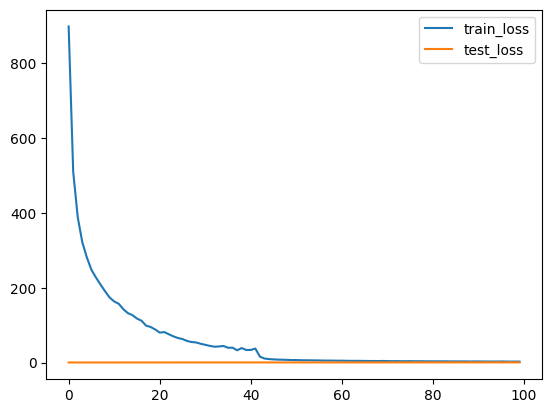

In [21]:
import pandas as pd
results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])